<a href="https://colab.research.google.com/github/speedy237/detection-des-anomalie-sur-les-indicateurs-mensuel/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#**Stratégie pour la détection des anomalies base sur le Calculer les variations:**


---



1.   Calculer les variations :

  *   Calculer les variations relatives ou absolues (selon le type de contrôle) entre les mesures d'un mois à l'autre.
  *   Comparer ces variations aux tolérances fournies dans la colonne tolerance_effective.

2.   Pondération des volumes :

  *   Introduire un paramètre de pondération pour ajuster la sensibilité des seuils selon la taille des volumes (les petits volumes étant plus sujets à des variations).

3.   Paramètre de configuration :

   *   Paramètre unique : facteur multiplicatif pour ajuster les tolérances (tolerance_effective).
   *   Paramètre optionnel : un seuil minimal de volume pour appliquer un contrôle.

4.   Classification des anomalies :

  *   Si une variation dépasse la tolérance, générer une alerte.


**Etape 0: Importation du Dataset**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/demo martine/output.csv',sep=';')
df.head(5)

,uuid,date,onglet,schema,table,indicateur,oi,date_snapshot,message_alerte,succes,criticity,type_controle,valeur_cible,valeur_mesure,tolerance_non_ponderee,ponderation_cible_double,tolerance_effective
0,beb944c8-731a-4d46-8ade-6606264ece0a,09/09/2024 17:44,pbo-pto,snapshots,kpi_arcep_cohort_cmd_stoc,num_racco,NATH,01/08/2024,NaN,True,\N,tolerance_pct,2260,1960,30,400,35
1,34f26adb-c14c-4ba8-a0f5-94a24847ac51,09/09/2024 17:44,pbo-pto,snapshots,kpi_arcep_cohort_cmd_stoc,num_racco,FTEL,01/08/2024,NaN,True,\N,tolerance_pct,57542,56116,30,400,30
2,8da54986-49bd-4b31-a407-c72710dea85d,09/09/2024 17:44,pbo-pto,snapshots,kpi_arcep_cohort_cmd_stoc,num_racco,SFRA,01/08/2024,NaN,True,\N,tolerance_pct,2305,2418,30,400,35
3,c346371c-e68b-45f8-97d1-db7e2b2f7c56,09/09/2024 17:44,pbo-pto,snapshots,kpi_arcep_cohort_cmd_stoc,num_racco,SIEL,01/08/2024,NaN,True,\N,tolerance_pct,656,518,30,400,48
4,57ac0d00-e5fa-40b4-9aa8-c721b56dee1e,09/09/2024 17:44,pbo-pto,snapshots,kpi_arcep_cohort_cmd_stoc,num_racco,COSL,01/08/2024,NaN,True,\N,tolerance_pct,515,506,30,400,53


**Étape 1 : Préparation des données**
*   Selection des colonnes utiles
*   Convertir les dates en format datetime pour permettre l'analyse temporelle
*   Trier les données par indicateur, oi, et date



In [ ]:
data=df[['date_snapshot','indicateur','oi','valeur_cible','valeur_mesure','tolerance_effective']]
data['date_snapshot'] = pd.to_datetime(data['date_snapshot'], format='%d/%m/%Y')
data.head(5)

<ipython-input-3-9e64055ee374>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_snapshot'] = pd.to_datetime(data['date_snapshot'], format='%d/%m/%Y')


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective
0,2024-08-01,num_racco,NATH,2260,1960,35
1,2024-08-01,num_racco,FTEL,57542,56116,30
2,2024-08-01,num_racco,SFRA,2305,2418,35
3,2024-08-01,num_racco,SIEL,656,518,48
4,2024-08-01,num_racco,COSL,515,506,53


In [ ]:
# Trier les données par indicateur oi et date
data = data.sort_values(by=['indicateur', 'oi','date_snapshot'])
data.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective
242,2024-08-01,cri_analyse,04CF,73,46,194
1584,2024-09-01,cri_analyse,04CF,46,19,290
2960,2024-09-01,cri_analyse,04CF,46,19,290
206,2024-08-01,cri_analyse,0GNY,50,58,270
1617,2024-09-01,cri_analyse,0GNY,58,30,236


**Etape 2: Calcul des variation**
*   **absolute_change** : Variation absolue de la mesure entre les périodes consécutives.
*   **relative_change** : Variation relative entre les périodes, exprimée en pourcentage.



In [ ]:
# Calcul de la variation absolue (différence entre mesures consécutives)
data['absolute_change'] = data.groupby(['indicateur', 'oi'])['valeur_mesure'].diff()
data.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change
242,2024-08-01,cri_analyse,04CF,73,46,194,NaN
1584,2024-09-01,cri_analyse,04CF,46,19,290,-27.0
2960,2024-09-01,cri_analyse,04CF,46,19,290,0.0
206,2024-08-01,cri_analyse,0GNY,50,58,270,NaN
1617,2024-09-01,cri_analyse,0GNY,58,30,236,-28.0


In [ ]:
# Calcul de la variation relative (en pourcentage)
data['relative_change'] = data['absolute_change'] / data['valeur_mesure'].shift(1)
data.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change,relative_change
242,2024-08-01,cri_analyse,04CF,73,46,194,NaN,NaN
1584,2024-09-01,cri_analyse,04CF,46,19,290,-27.0,-0.586957
2960,2024-09-01,cri_analyse,04CF,46,19,290,0.0,0.000000
206,2024-08-01,cri_analyse,0GNY,50,58,270,NaN,NaN
1617,2024-09-01,cri_analyse,0GNY,58,30,236,-28.0,-0.482759


In [ ]:
data.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change,relative_change
242,2024-08-01,cri_analyse,04CF,73,46,194,NaN,NaN
1584,2024-09-01,cri_analyse,04CF,46,19,290,-27.0,-0.586957
2960,2024-09-01,cri_analyse,04CF,46,19,290,0.0,0.000000
206,2024-08-01,cri_analyse,0GNY,50,58,270,NaN,NaN
1617,2024-09-01,cri_analyse,0GNY,58,30,236,-28.0,-0.482759


**Étape 3 : Détection des anomalies**

*   Définir une fonction pour détecter les anomalies

 Arguments :
    - row : Ligne du DataFrame contenant les colonnes nécessaires
    - sensitivity_factor : Facteur pour ajuster la sensibilité des seuils

    Retour :
    - True si une anomalie est détectée, sinon False
*   Détecte les anomalies en fonction de la variation absolue et des tolérances.

   

In [ ]:
def detect_anomalies(row, sensitivity_factor=1.0):
    """
    Détecte les anomalies en fonction de la variation absolue et des tolérances.

    Arguments :
    - row : Ligne du DataFrame contenant les colonnes nécessaires
    - sensitivity_factor : Facteur pour ajuster la sensibilité des seuils

    Retour :
    - True si une anomalie est détectée, sinon False
    """
    if pd.isnull(row['absolute_change']) or pd.isnull(row['relative_change']):
        return False  # Pas de donnée précédente pour comparaison
    tolerance = row['tolerance_effective'] * sensitivity_factor
    # Vérifie si la variation absolue dépasse la tolérance
    if abs(row['absolute_change']) > tolerance:
        return True
    return False

In [ ]:
# Appliquer la fonction aux données
sensitivity_factor = 1.0  # Paramètre ajustable
data['is_anomalous'] = data.apply(detect_anomalies, sensitivity_factor=sensitivity_factor, axis=1)

In [ ]:
data.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change,relative_change,is_anomalous
242,2024-08-01,cri_analyse,04CF,73,46,194,NaN,NaN,False
1584,2024-09-01,cri_analyse,04CF,46,19,290,-27.0,-0.586957,False
2960,2024-09-01,cri_analyse,04CF,46,19,290,0.0,0.000000,False
206,2024-08-01,cri_analyse,0GNY,50,58,270,NaN,NaN,False
1617,2024-09-01,cri_analyse,0GNY,58,30,236,-28.0,-0.482759,False


In [ ]:
anomalies = data[data['is_anomalous'] == True]

In [ ]:
len(anomalies)

347

In [ ]:
print("Anomalies détectées :")
anomalies.head(5)

# Exporter les anomalies dans un fichier CSV
anomalies.to_csv('anomalies_detectees_stats.csv', index=False)

Anomalies détectées :


In [ ]:
anomalies

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change,relative_change,is_anomalous
1582,2024-09-01,cri_analyse,0TCA,467,299,55,-168.0,-0.359743,True
1588,2024-09-01,cri_analyse,0THS,488,330,54,-158.0,-0.323770,True
1577,2024-09-01,cri_analyse,0TSO,449,362,56,-87.0,-0.193764,True
1598,2024-09-01,cri_analyse,ADTH,529,340,52,-189.0,-0.357278,True
1570,2024-09-01,cri_analyse,AISN,311,230,68,-81.0,-0.260450,True
...,...,...,...,...,...,...,...,...,...
2299,2024-09-01,stoc_sans_cr,VDLF,695,485,47,-210.0,-0.302158,True
2284,2024-09-01,stoc_sans_cr,VENU,782,405,45,-377.0,-0.482097,True
2293,2024-09-01,stoc_sans_cr,VTHD,1093,579,40,-514.0,-0.470265,True
2264,2024-09-01,stoc_sans_cr,WIGA,407,304,59,-103.0,-0.253071,True


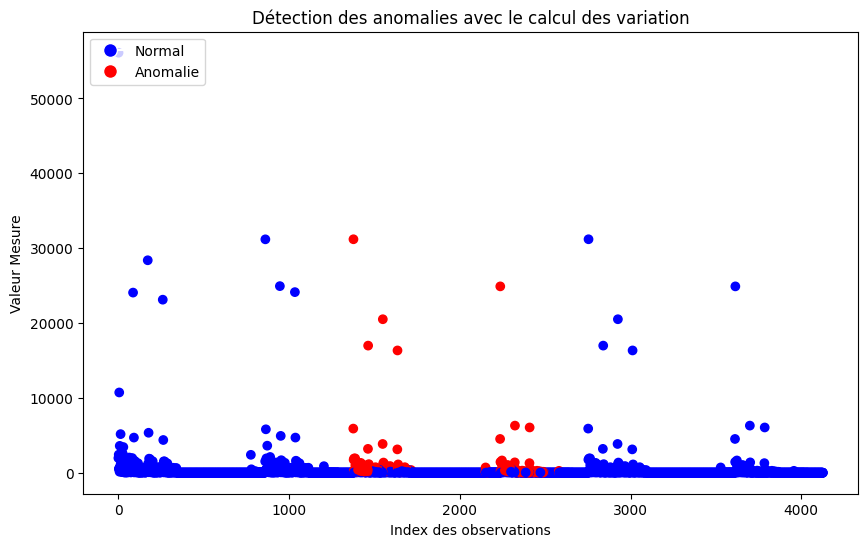

In [ ]:
import matplotlib.pyplot as plt
colors = data['is_anomalous'].apply(lambda x: 'red' if x else 'blue')

plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['valeur_mesure'], c=colors, label='Données')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalie')
]
plt.legend(handles=handles, loc='upper left')

# Ajouter des titres et labels
plt.title("Détection des anomalies avec le calcul des variation")
plt.xlabel("Index des observations")
plt.ylabel("Valeur Mesure")
plt.show()


#**Strategie base sur le calcul de la moyenne et l'ecart type**

**Principe**

1.   Calculer la moyenne et l'écart type des valeurs historiques pour chaque indicateur.
2.   Considérer une mesure comme anormale si elle s'éloigne de la moyenne de plus d'un certain nombre d'écarts types (paramétrable).






---



**Etape 1: Preparation des donnees**

In [ ]:
data2=df[['date_snapshot','indicateur','oi','valeur_cible','valeur_mesure','tolerance_effective']]
data2['date_snapshot'] = pd.to_datetime(data2['date_snapshot'], format='%d/%m/%Y')
data2 = data2.sort_values(by=['indicateur', 'oi','date_snapshot'])
data2.head(5)

<ipython-input-16-b965202c9372>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['date_snapshot'] = pd.to_datetime(data2['date_snapshot'], format='%d/%m/%Y')


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective
242,2024-08-01,cri_analyse,04CF,73,46,194
1584,2024-09-01,cri_analyse,04CF,46,19,290
2960,2024-09-01,cri_analyse,04CF,46,19,290
206,2024-08-01,cri_analyse,0GNY,50,58,270
1617,2024-09-01,cri_analyse,0GNY,58,30,236


**Étape 2 : Calcul des statistiques (moyenne et écart type)**


*   Calculer la moyenne et l'écart type pour chaque indicateur et organisation




In [ ]:
data2['historical_mean'] = data2.groupby(['indicateur', 'oi'])['valeur_mesure'].transform('mean')
data2['historical_std'] = data2.groupby(['indicateur', 'oi'])['valeur_mesure'].transform('std')

In [ ]:
data2.head(5)

,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,historical_mean,historical_std
242,2024-08-01,cri_analyse,04CF,73,46,194,28.000000,15.588457
1584,2024-09-01,cri_analyse,04CF,46,19,290,28.000000,15.588457
2960,2024-09-01,cri_analyse,04CF,46,19,290,28.000000,15.588457
206,2024-08-01,cri_analyse,0GNY,50,58,270,39.333333,16.165808
1617,2024-09-01,cri_analyse,0GNY,58,30,236,39.333333,16.165808


**Étape 3 : Détection des anomalies**


*   Définir un seuil en termes d'écarts types


*   Ecrire une Fonction pour Détecter les anomalies en fonction de l'écart à la moyenne

    Arguments :
    - row : Ligne du DataFrame contenant les colonnes nécessaires
    - threshold_std : Nombre d'écarts types tolérés autour de la moyenne

    Retour :
    - True si une anomalie est détectée, sinon False






In [ ]:
threshold_std = 2  # Paramètre ajustable (par défaut 2 écarts types)

In [ ]:
# Détecter les anomalies
def detect_anomalies_with_stats(row, threshold_std=2):

    if pd.isnull(row['historical_mean']) or pd.isnull(row['historical_std']):
        return False  # Pas assez de données historiques
    deviation = abs(row['valeur_mesure'] - row['historical_mean'])
    if deviation > threshold_std * row['historical_std']:
        return True
    return False

In [ ]:
# Appliquer la fonction aux données
data2['is_anomalous'] = data2.apply(detect_anomalies_with_stats, threshold_std=threshold_std, axis=1)

data2.head(5)


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,historical_mean,historical_std,is_anomalous
242,2024-08-01,cri_analyse,04CF,73,46,194,28.000000,15.588457,False
1584,2024-09-01,cri_analyse,04CF,46,19,290,28.000000,15.588457,False
2960,2024-09-01,cri_analyse,04CF,46,19,290,28.000000,15.588457,False
206,2024-08-01,cri_analyse,0GNY,50,58,270,39.333333,16.165808,False
1617,2024-09-01,cri_analyse,0GNY,58,30,236,39.333333,16.165808,False


In [ ]:
anomalies2 = data[data['is_anomalous'] == True]
anomalies2.head(5)


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective,absolute_change,relative_change,is_anomalous
1582,2024-09-01,cri_analyse,0TCA,467,299,55,-168.0,-0.359743,True
1588,2024-09-01,cri_analyse,0THS,488,330,54,-158.0,-0.323770,True
1577,2024-09-01,cri_analyse,0TSO,449,362,56,-87.0,-0.193764,True
1598,2024-09-01,cri_analyse,ADTH,529,340,52,-189.0,-0.357278,True
1570,2024-09-01,cri_analyse,AISN,311,230,68,-81.0,-0.260450,True


In [ ]:
len(anomalies2)

347

In [ ]:
# Exporter les anomalies dans un fichier CSV
anomalies2.to_csv('anomalies_detectees_stats.csv', index=False)

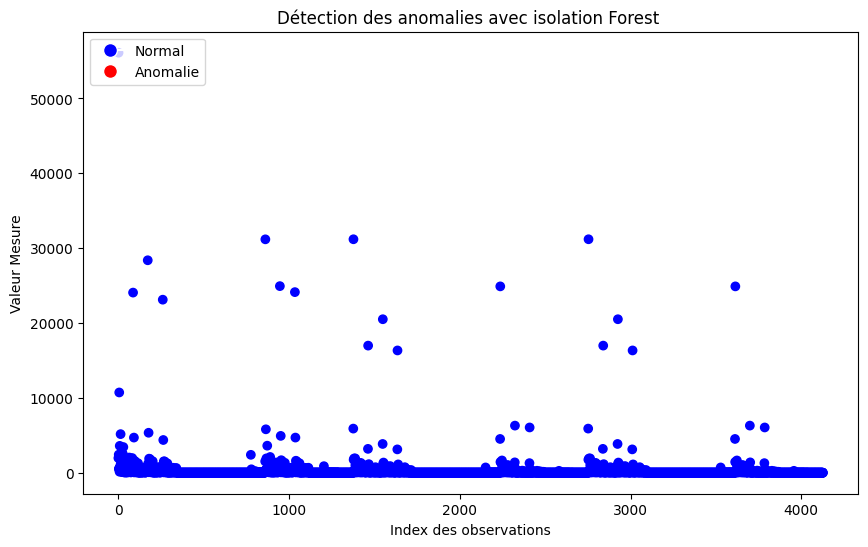

In [ ]:
colors = data2['is_anomalous'].apply(lambda x: 'red' if x else 'blue')

plt.figure(figsize=(10, 6))
plt.scatter(data2.index, data2['valeur_mesure'], c=colors, label='Données')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalie')
]
plt.legend(handles=handles, loc='upper left')

# Ajouter des titres et labels
plt.title("Détection des anomalies avec isolation Forest ")
plt.xlabel("Index des observations")
plt.ylabel("Valeur Mesure")
plt.show()



# **C) Strategie Base sur le Machine Learning**



*   Isolation Forest
*   K Nearest Neighbors



1) Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

Étape 1 : Preparation des donnees

In [ ]:
data3=df[['date_snapshot','indicateur','oi','valeur_cible','valeur_mesure','tolerance_effective']]
data3['date_snapshot'] = pd.to_datetime(data3['date_snapshot'], format='%d/%m/%Y')
data3 = data3.sort_values(by=['indicateur', 'oi','date_snapshot'])
data3.head(5)

<ipython-input-27-05596a2c87bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['date_snapshot'] = pd.to_datetime(data3['date_snapshot'], format='%d/%m/%Y')


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective
242,2024-08-01,cri_analyse,04CF,73,46,194
1584,2024-09-01,cri_analyse,04CF,46,19,290
2960,2024-09-01,cri_analyse,04CF,46,19,290
206,2024-08-01,cri_analyse,0GNY,50,58,270
1617,2024-09-01,cri_analyse,0GNY,58,30,236


In [ ]:
# Conserver uniquement les colonnes nécessaires pour la détection
data_subset = data3[['valeur_mesure', 'tolerance_effective']].copy()


Étape 2 : Détection des anomalies avec Isolation Forest

*   Initialisation du modèle


In [ ]:


iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Ajustement et prédiction
data_subset['anomaly_score'] = iso_forest.fit_predict(data_subset)

In [ ]:
# Les anomalies sont marquées par -1
data3['is_anomalous'] = data_subset['anomaly_score'] == -1

In [ ]:
#Filtrer les anomalies
anomalies3 = data3[data3['is_anomalous'] == True]

In [ ]:
len(anomalies3)

192

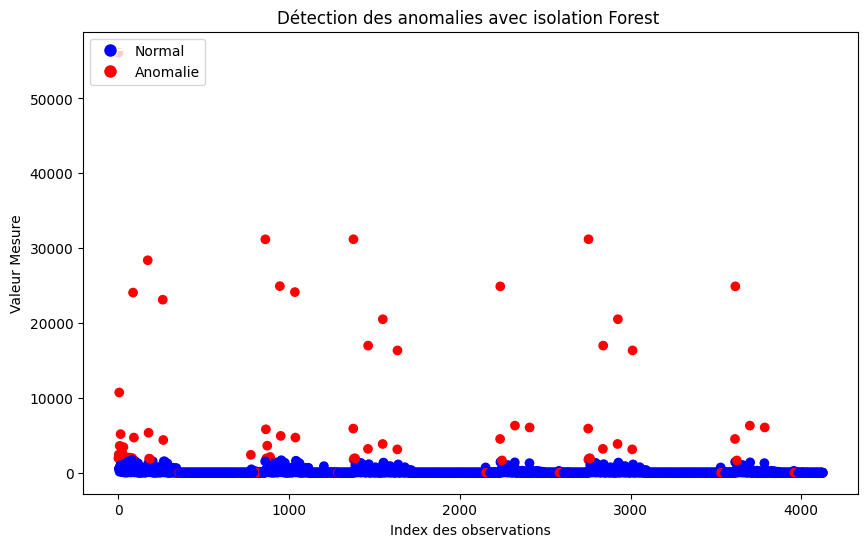

In [ ]:
colors = data3['is_anomalous'].apply(lambda x: 'red' if x else 'blue')

plt.figure(figsize=(10, 6))
plt.scatter(data3.index, data3['valeur_mesure'], c=colors, label='Données')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalie')
]
plt.legend(handles=handles, loc='upper left')

# Ajouter des titres et labels
plt.title("Détection des anomalies avec isolation Forest ")
plt.xlabel("Index des observations")
plt.ylabel("Valeur Mesure")
plt.show()




2.   K Nearest Neighbors


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Étape 1 : Sélection des variables pertinentes
data4=df[['date_snapshot','indicateur','oi','valeur_cible','valeur_mesure','tolerance_effective']]
data4['date_snapshot'] = pd.to_datetime(data4['date_snapshot'], format='%d/%m/%Y')
data4 = data4.sort_values(by=['indicateur', 'oi','date_snapshot'])
data4.head(5)



<ipython-input-35-0e5359cec672>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['date_snapshot'] = pd.to_datetime(data4['date_snapshot'], format='%d/%m/%Y')


,date_snapshot,indicateur,oi,valeur_cible,valeur_mesure,tolerance_effective
242,2024-08-01,cri_analyse,04CF,73,46,194
1584,2024-09-01,cri_analyse,04CF,46,19,290
2960,2024-09-01,cri_analyse,04CF,46,19,290
206,2024-08-01,cri_analyse,0GNY,50,58,270
1617,2024-09-01,cri_analyse,0GNY,58,30,236


In [ ]:
# Étape 2 : Sélection des variables pertinentes
# Conserver uniquement les colonnes nécessaires pour la détection
data_subset2 = data4[['valeur_mesure', 'tolerance_effective']].copy()



In [ ]:
# Étape 3 : Implémentation de k-NN pour la détection d'anomalies
# Initialisation du modèle k-NN
k = 5  # Nombre de voisins à considérer
nbrs = NearestNeighbors(n_neighbors=k).fit(data_subset)

# Calculer les distances aux k plus proches voisins
distances, _ = nbrs.kneighbors(data_subset)



In [ ]:
# Calcul de la distance moyenne aux k voisins
data_subset2['mean_distance'] = distances.mean(axis=1)

# Détection des anomalies : définir un seuil
threshold = data_subset2['mean_distance'].quantile(0.95)  # Les 5% des points les plus éloignés sont des anomalies

# Marquer les anomalies
data4['is_anomalous'] = data_subset2['mean_distance'] > threshold


In [ ]:
# Étape 4 : Filtrer les anomalies
anomalies4 = data4[data4['is_anomalous'] == True]

In [ ]:
len(anomalies4)

207

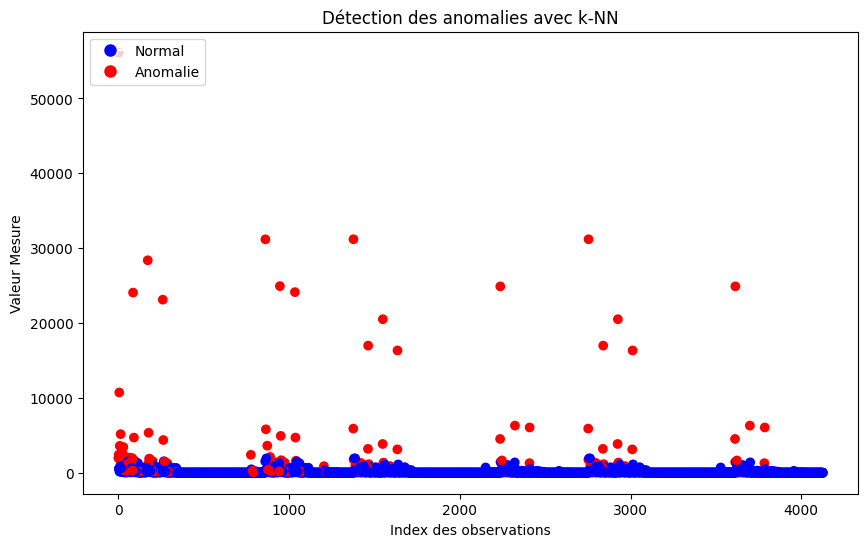

In [ ]:

colors = data4['is_anomalous'].apply(lambda x: 'red' if x else 'blue')

plt.figure(figsize=(10, 6))
plt.scatter(data4.index, data4['valeur_mesure'], c=colors, label='Données')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalie')
]
plt.legend(handles=handles, loc='upper left')

# Ajouter des titres et labels
plt.title("Détection des anomalies avec k-NN")
plt.xlabel("Index des observations")
plt.ylabel("Valeur Mesure")
plt.show()
